# Data Science PI7, Part 1

### 1. SQL Database Analysis

To assess the available values in our database ("cycling_big.db"), we will have to explore our database.
We will import the necessary modules and then make a query to our database by calling //the names of the tables and their column values//

Note that these operations are better handled by data handling and manipulation modules, like Pandas, which will be used later on.

In [90]:
import sqlite3 as lite
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
conn = lite.connect('cycling_big.db')
cur = conn.cursor()

cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()

print("The following tables are present in our database")
for row in tables:
    print(row)

# We will be closing the database connection at the end of each code cell.
# By doing this we can make sure that queries dont interact with unwanted code cells.
conn.close()

The following tables are present in our database
('riders',)
('race_results',)
('sqlite_sequence',)


Note that the tables 'riders' and 'race_results' are present in the database. 
With this information, a query can be made to print out the first ten rows from our tables.

In [92]:
conn = lite.connect('cycling_big.db')
cur = conn.cursor()

conn = lite.connect('cycling_big.db')

# Execute a query to select all entries and put the labels in an arrary of description values

cur.execute('SELECT * FROM race_results')

columns_race = [description[0] for description in cur.description]

print("Columns for race_results:", columns_race)

cur.execute('SELECT * FROM riders')

columns_rider = [description[0] for description in cur.description]

print("Columns for riders:", columns_rider)

conn.close()

Columns for race_results: ['id', 'Rnk', 'GC', 'Timelag', 'BiB', 'Rider', 'Age', 'Team', 'UCI', 'Pnt', 'Time', 'Circuit', 'Race_Name', 'Stage_Name', 'Date', 'Stage_Type', 'Start', 'Finish', 'Race_ID', 'Stage_Number', 'Length', 'Category', 'Race_url', 'Stage_url', 'rider_id']
Columns for riders: ['rider_id', 'fullname', 'team', 'birthdate', 'country', 'height', 'weight', 'rider_url', 'pps', 'rdr']


#### Evaluating empty values quickly
Now let's quickly identify the amount of empty cells for race results. 
This will not give a full scope of missing or incorrect data, but this will offer us a quick overview of the columns that are missing entries.
Ofcourse, entry values like 'Date' can be expected to be unstandardized, or a value can be entered as 'null', but will still count as a value, so using SQL queries will not be the most accurate to determine missing or unstandardized data.

In [93]:
conn = lite.connect('cycling_big.db')
cur = conn.cursor()

cur.execute("PRAGMA table_info(race_results);") # Quick and dirty PRAGMA statement to return info on a column
columns = cur.fetchall()

# Building an SQL query to loop through all the columns to count nulls
null_count = "SELECT "

# Add each column's NULL count
null_count += ", ".join([f"SUM(CASE WHEN {column[1]} IS NULL THEN 1 ELSE 0 END) AS {column[1]}_null" for column in columns])

null_count += " FROM race_results;"

# Execute the query
cur.execute(null_count)

# Fetch the result
null_counts = cur.fetchone()

print("\nMissing Values Count for Each Column:")
print("-" * 50)
print(f"{'Column Name':<30} {'Missing Values'}")
print("-" * 50)

# Looping through the columns and applying formatting
for i, column in enumerate(columns):
    column_name = column[1]  # Column name is the second element in the tuple
    missing_values = null_counts[i]
    print(f"{column_name:<30} {missing_values:>15}")

print("-" * 50)

conn.close()


Missing Values Count for Each Column:
--------------------------------------------------
Column Name                    Missing Values
--------------------------------------------------
id                                           0
Rnk                                          0
GC                                       30420
Timelag                                  30420
BiB                                          0
Rider                                        0
Age                                          0
Team                                        29
UCI                                     214074
Pnt                                     194158
Time                                         0
Circuit                                      0
Race_Name                                    0
Stage_Name                               25241
Date                                         0
Stage_Type                                   0
Start                                        0
Finish        

### 2. Database Extraction and Deserialization

Below is a code sample for extracting data from a SQLite database. Using the built in 'sqlite' module for python, we can open a connection by calling the 'connect()' function that points to a "*.db" file. The returned connection object, named 'conn', represents the connection to the on-disk database. This essentially creates an interface for python to interact with the SQLite database. Using the 'Pandas' module, we can put this deserialized data from the database into a dataframe. A dataframe preserves the rows and columns from the relevant database. By using this data frame, the data from the database can be used for data handling, manipulation and further analysis.

In [94]:
# As shown in the above cells, a connection to the ".db" file can be established by 
conn = lite.connect("cycling_big.db")

table_names = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn) # Sqlite master is a system table that holds information like table names 
df = pd.read_sql(f"SELECT * FROM {table_names['name'][0]}", conn) # Access the first tables name from the table_names dataframe

conn.close()

df.head()

,rider_id,fullname,team,birthdate,country,height,weight,rider_url,pps,rdr
0,5e4c220d0657face20e49719b725a001,BARDET Romain,Team DSM,1990-11-09,France,1.84,65.0,https://www.procyclingstats.com/rider/romain-b...,"{'One day races': '2620', 'GC': '5138', 'Time ...","{'PCS Ranking': '43', 'UCI World Ranking': '52..."
1,995d110d3b2e05830409874b401a3218,DUMOULIN Samuel,noteam,1980-08-20,France,1.59,57.0,https://www.procyclingstats.com/rider/samuel-d...,"{'One day races': '3681', 'GC': '1277', 'Time ...",{'Specials | All Time Ranking': '365'}
2,21b52056733e39f06885dfb9d18bc77a,GALLOPIN Tony,AG2R Citroën Team,1988-05-24,France,1.80,69.0,https://www.procyclingstats.com/rider/tony-gal...,"{'One day races': '2864', 'GC': '2268', 'Time ...","{'PCS Ranking': '511', 'UCI World Ranking': '9..."
3,3fe13c77eb187357fa58c810a7aa7083,NAESEN Oliver,AG2R Citroën Team,1990-09-16,Belgium,1.84,72.0,https://www.procyclingstats.com/rider/oliver-n...,"{'One day races': '3619', 'GC': '1157', 'Time ...","{'PCS Ranking': '203', 'UCI World Ranking': '1..."
4,ae00cdf6b464b193c1a34e08fe1eded7,FRANK Mathias,noteam,1986-12-09,Switzerland,1.76,64.0,https://www.procyclingstats.com/rider/mathias-...,"{'One day races': '702', 'GC': '2803', 'Time t...","{'PCS Ranking': '755', 'UCI World Ranking': '9..."


### 3. Exploratory Data Analysis

Exploratory analysis can be used to identify extreme cases and determine wether they should be eliminated.

Boxplots will be made to identify outliers in the following features: race time and ranking.
Scatterplots will be made to identify relations between the following continuous variables: age vs ranking and weight vs race position.
A histogram will be made to analyze the distribution of numeric data for the distribution of points among cyclists.

In [95]:
conn = lite.connect('cycling_big.db')

riders_df = pd.read_sql_query('SELECT * FROM riders;', conn)
races_df = pd.read_sql_query('SELECT * FROM race_results', conn)

# Combine the tables so we can use variables from the two tables for analysis
# We attach rider information to races table, so that every entry in the races will have additional information on the rider
# rider_id is the key connecting the tables
df = races_df.set_index('rider_id').join(riders_df.set_index('rider_id'))

conn.close()
df.head(3)

,id,Rnk,GC,Timelag,BiB,Rider,Age,Team,UCI,Pnt,...,Stage_url,fullname,team,birthdate,country,height,weight,rider_url,pps,rdr
rider_id,,,,,,,,,,,,,,,,,,,,,
659ed585810c65fe22255a5e4a9b7838,1,1,1.0,+0:00,0,GREIPEL André,29,Lotto Belisol Team,6.0,50.0,...,/stage-1/result/result,GREIPEL André,Israel Start-Up Nation,1982-07-16,Germany,1.84,80.0,https://www.procyclingstats.com/rider/andre-gr...,"{'One day races': '4650', 'GC': '1921', 'Time ...","{'PCS Ranking': '133', 'UCI World Ranking': '2..."
None,2,2,2.0,+0:04,0,PETACCHI Alessandro,38,Lampre - ISD,4.0,30.0,...,/stage-1/result/result,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
None,3,3,4.0,+0:06,0,HUTAROVICH Yauheni,28,FDJ - BigMat,2.0,18.0,...,/stage-1/result/result,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225918 entries, 0 to 225917
Data columns (total 33 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            225918 non-null  int64  
 1   Rnk           225918 non-null  object 
 2   GC            195498 non-null  float64
 3   Timelag       195498 non-null  object 
 4   BiB           225918 non-null  object 
 5   Rider         225918 non-null  object 
 6   Age           225918 non-null  int64  
 7   Team          225889 non-null  object 
 8   UCI           11844 non-null   float64
 9   Pnt           31760 non-null   float64
 10  Time          225918 non-null  object 
 11  Circuit       225918 non-null  int64  
 12  Race_Name     225918 non-null  object 
 13  Stage_Name    200677 non-null  object 
 14  Date          225918 non-null  object 
 15  Stage_Type    225918 non-null  object 
 16  Start         225918 non-null  object 
 17  Finish        225918 non-null  object 
 18  Race

<Axes: ylabel='Pnt'>

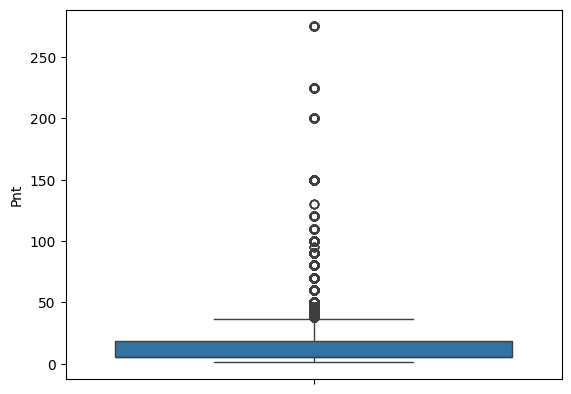

In [119]:
sns.boxplot(data=df['Pnt'])

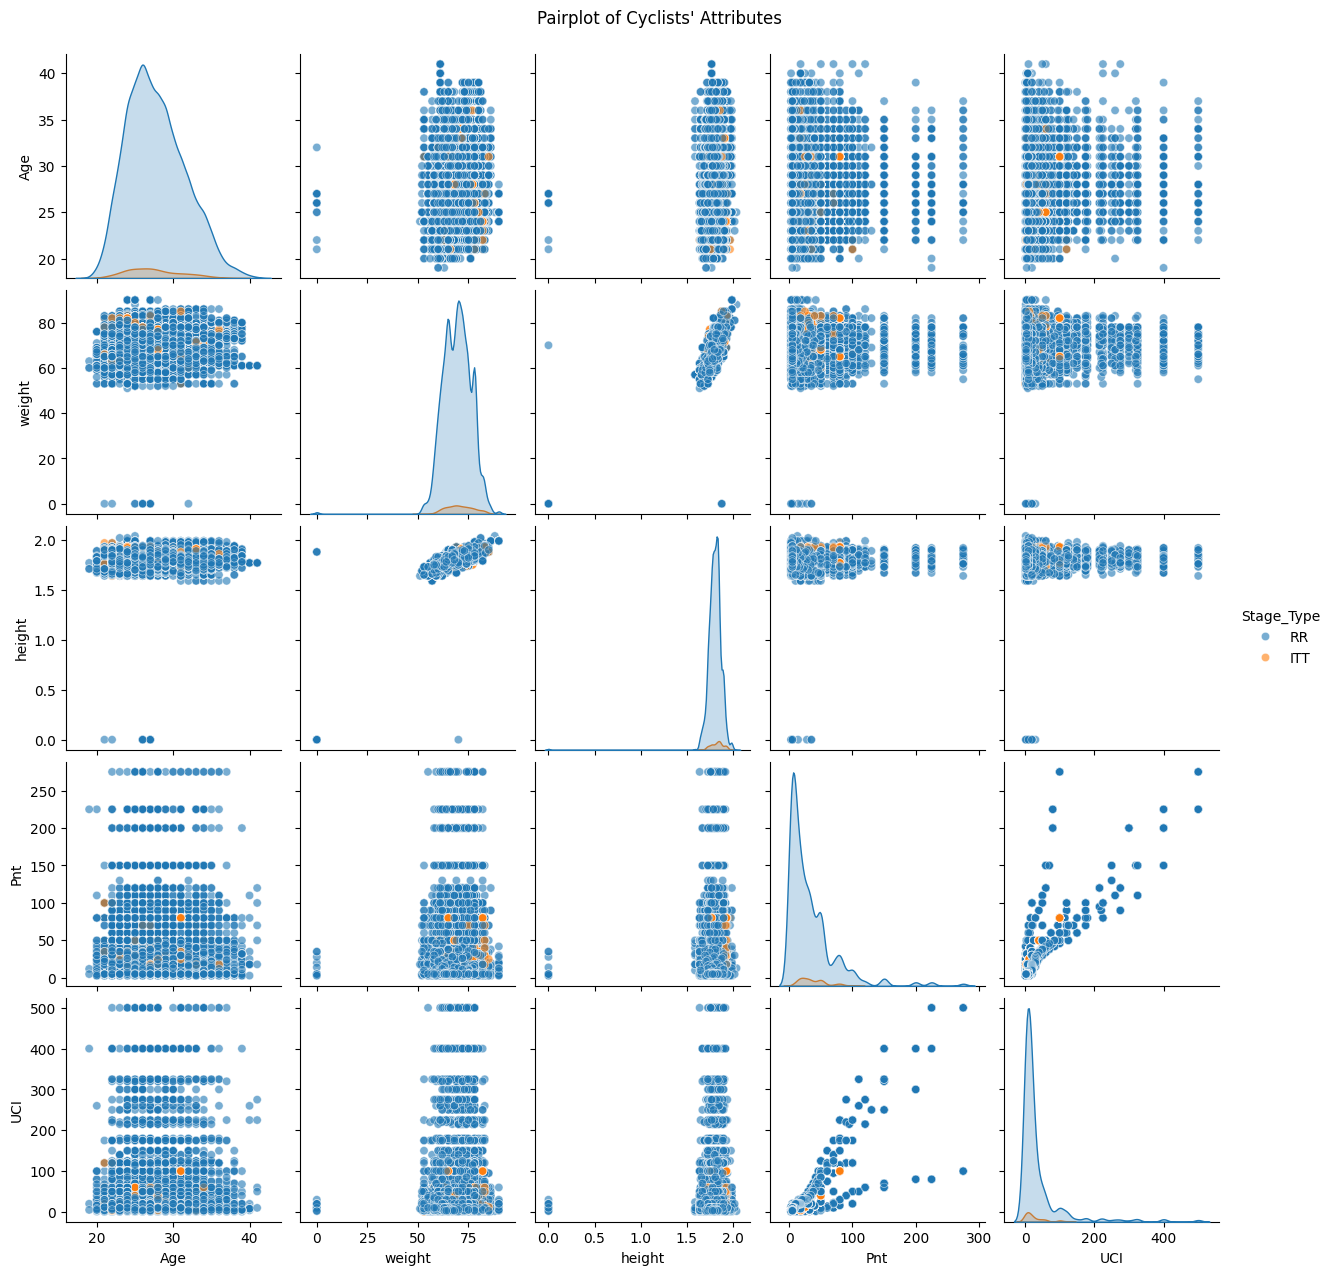

In [114]:
relevant_columns = ['Age', 'weight', 'height', 'Pnt', 'UCI', 'Stage_Type']
df_clean = df[relevant_columns].dropna()
# Create pairplot to visualize relationships between numeric columns
sns.pairplot(df_clean[relevant_columns], kind='scatter', plot_kws={'alpha': 0.6}, hue='Stage_Type')
plt.suptitle("Pairplot of Cyclists' Attributes", y=1.02)
plt.show()

/home/impl1ng/Documents/DatSci_PI7-1/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/impl1ng/Documents/DatSci_PI7-1/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/impl1ng/Documents/DatSci_PI7-1/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/impl1ng/Documents/DatSci_PI7-1/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/impl1ng/Documents/DatSci_PI7-1/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, 

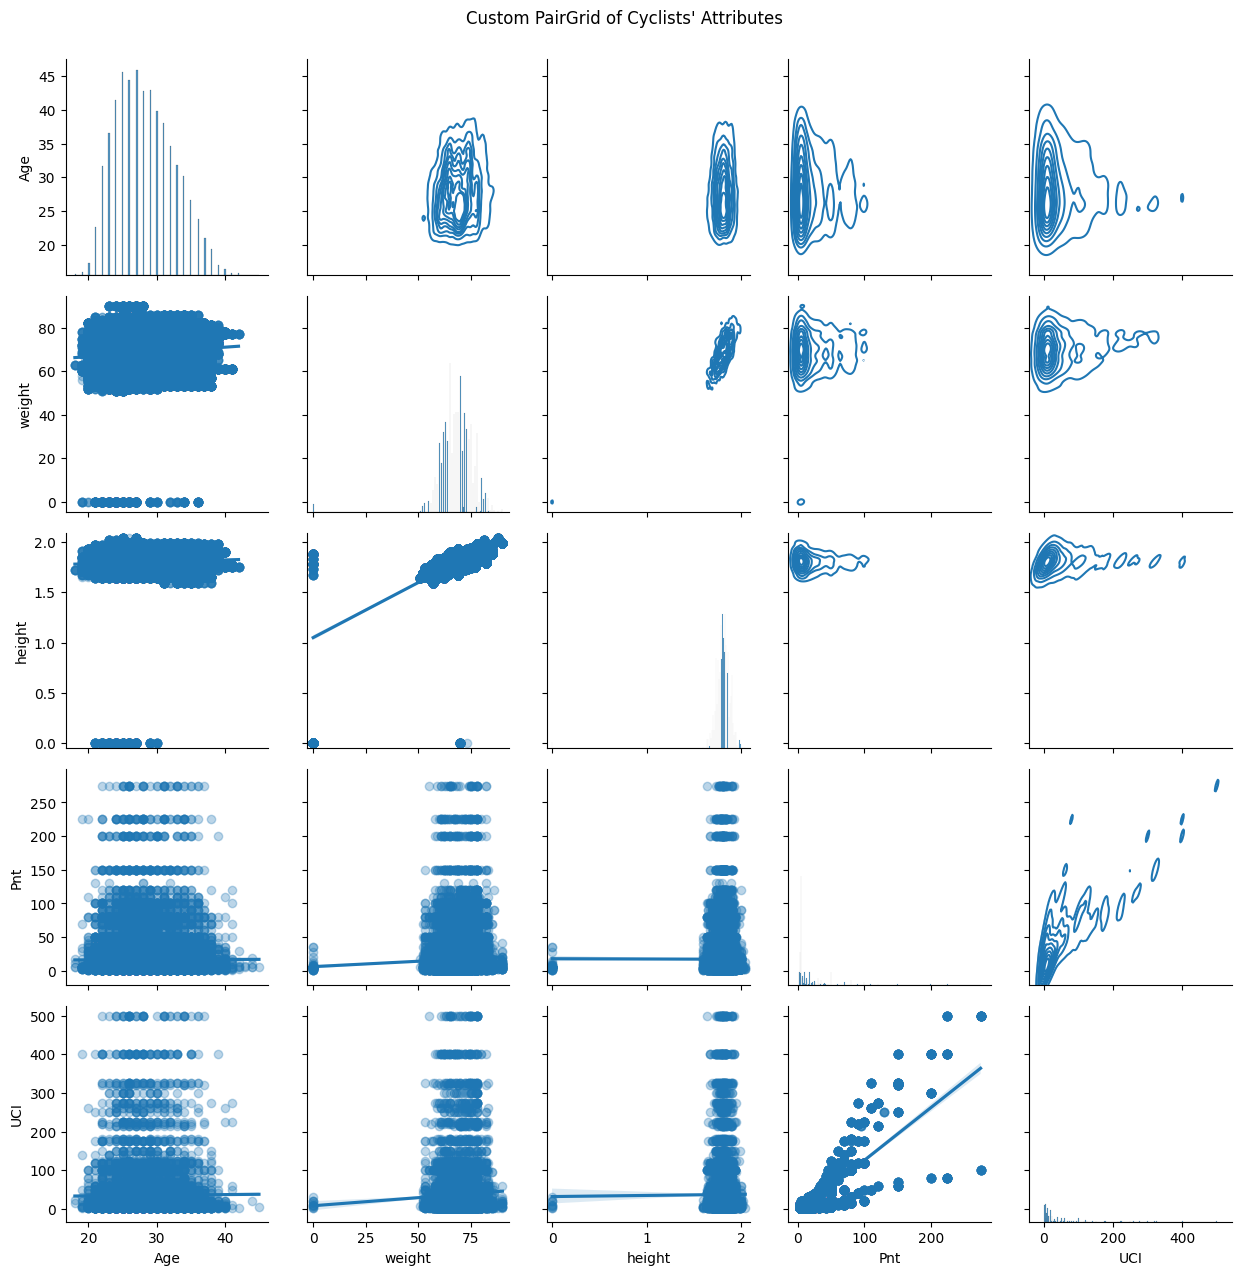

In [117]:
g = sns.PairGrid(df[relevant_columns], palette="tab20")

# Use scatter plots in the lower triangle, KDE on the upper triangle, and histograms on the diagonal
g.map_lower(sns.regplot, scatter_kws={'alpha': 0.3})  # Regression plots in the lower triangle
g.map_upper(sns.kdeplot)  # KDE plots in the upper triangle
g.map_diag(sns.histplot, kde_kws={'color': 'black'})  # Histograms on the diagonal

# Show the plot with legends
g.add_legend()
plt.suptitle("Custom PairGrid of Cyclists' Attributes", y=1.02)
plt.show()

# 4. Quality of the Data

The quality of the data will be identified by the following characteristics:
- Completeness:
- Consistency:
- Accuracy:
- Timeliness:

In [ ]:
print(df.isnull().sum())